In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [2]:
!pip install kaggle

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
    
!kaggle competitions download -c dog-breed-identification -p data/ && cd data && ls && unzip train.zip && unzip test.zip && unzip labels.csv.zip

Download 100%.
labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
labels.csv	sample_submission.csv.zip  test.zip  train.zip
labels.csv.zip	test			   train
Archive:  train.zip
replace train/000bec180eb18c7604dcecc8fe0dba07.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [0]:
import numpy as np
import torchvision.transforms as transforms
import torch

In [4]:
print("{} GPU's available:".format(torch.cuda.device_count()) )
cpu_count = torch.multiprocessing.cpu_count()
print("\ncpu_count: {}".format(cpu_count))

1 GPU's available:

cpu_count: 2


In [5]:
use_gpu = True
use_DataParalel= True
use_CPU= False        

if use_gpu:
    if use_DataParalel: 
        print("Using DataParalel in all {} GPUS".format(torch.cuda.device_count()))

    else:
        print('Using only one GPU')

if use_CPU:         # http://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html 
    print("Using {} CPU's".format(cpu_count))

Using DataParalel in all 1 GPUS


In [0]:
path2train = "data/train" 
path2test = "data/test"

In [0]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

img_width = img_height=300 #to use InceptionV3 it must img_width and img_height be changed to 300

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

In [0]:
from torch.utils.data import Dataset
import random
from PIL import Image
import pandas as pd


class KaggleDataset(Dataset):
    
    def __init__(self, path, transforms=None):
    
        labels_df = pd.read_csv('data/labels.csv')
    
        self.transform = transforms        

        self.X = []
        self.y = []

        for index, row in labels_df.iterrows():
            file_path = os.path.join(path, str(row['id']) + '.jpg')
            file_label = row['breed']
            self.X.append(file_path)
            self.y.append(file_label)

    
    def __getitem__(self, index):
        path = self.X[index]
        label = self.y[index]
        with open(path, 'rb') as f:
            flbase = os.path.basename(path)
            '''
            if self.is_test:
                id_img = re.findall('\d+', flbase)
                label = int(id_img[0])
            '''
            with Image.open(f) as img:
                 image = img.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.X)


In [0]:
batch_size = 32
use_only = 1.0 # Use only is the percentage of the full dataset

In [0]:
dsets = {
    'train': KaggleDataset(path2train, transforms=data_transforms['train'])
}

In [0]:
from torch.utils.data import DataLoader



def create_dataLoader(dsets, batch_size,  pin_memory=False, use_shuffle=False):
    dset_loaders = {}
   
    shuffle = False
    for key in dsets.keys():
        if use_shuffle:
            if key != 'test':
                shuffle = True
            else:
                shuffle = False
        dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, pin_memory=pin_memory, shuffle = shuffle)
            
    return dset_loaders

In [0]:
dset_loaders = create_dataLoader(dsets, batch_size, pin_memory=False, use_shuffle= True)

In [0]:
import numpy as np

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))  # Channel Last
    img = std * inp + mean
    return img

In [0]:
import matplotlib.pyplot as plt

def plot_classes(dset_loaders, path2save = './figures/data.png'):
    inputs, cls = next(iter(dset_loaders))
    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,10)):
        fig.add_subplot(2,5, i+1)
        img = denormalize(inputs.numpy()[j])
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        plt.title('{}'.format(cls[j]))
        plt.axis('off')

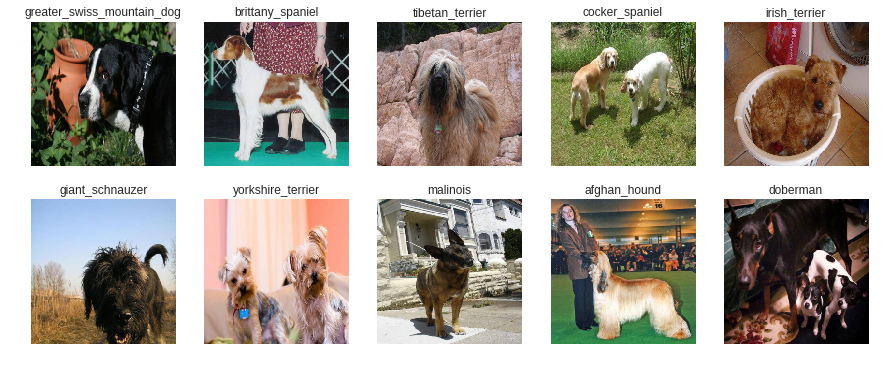

In [28]:
plot_classes(dset_loaders['train'])
